# Visualise embeddings of the JDE model

This notebook embeds images from the training data using the JDE model. It then collects all embeddings and projects them using different techniques (e.g. UMAP, PCA). These projections are plotted; try to hover the plot to see the source detection.

In a second step these images are drawn onto a canvas using the projected points.

In [1]:
import glob
import pickle
from typing import TypedDict
from tqdm.auto import tqdm

import os
import numpy as np

import logging
import argparse
logger = logging.getLogger(__name__)

In [2]:
from track import eval_seq

from utils.parse_config import parse_model_cfg
from utils.utils import mkdir_if_missing
import utils.datasets as datasets
from utils.log import logger as trmlog # we need to override this...


trmlog.setLevel(logging.INFO)

2023-04-06 16:09:23 [WARNING]: Matplotlib created a temporary config/cache directory at /tmp/matplotlib-i8r80tk_ because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2023-04-06 16:09:23 [INFO]: generated new fontManager


In [3]:
import umap # should provide better results than t-SNE



In [4]:
# import matplotlib.pyplot as plt

from bokeh.io import curdoc, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.layouts import column, row, gridplot
from bokeh.plotting import figure, show
from bokeh.models import (PanTool,
                           ResetTool,
                          HoverTool, WheelZoomTool, BoxZoomTool)

# load bokeh
output_notebook()


Loading BokehJS ...

In [5]:
# p1 = figure(plot_width=250, plot_height=250)
# r1 = p1.circle([1,2,3],[3,2,1], size=20)

# t = show(p1, notebook_handle=True)

In [26]:
img_seqs = [
    "MOT16/test/MOT16-01/",
    "MOT16/test/MOT16-03/",
    "MOT16/test/MOT16-06/",
    "MOT16/test/MOT16-07/",
    "MOT16/test/MOT16-08/",
    "MOT16/test/MOT16-12/",
    "MOT16/test/MOT16-14/",
    "MOT16/train/MOT16-02/",
    "MOT16/train/MOT16-04/",
    "MOT16/train/MOT16-05/",
    "MOT16/train/MOT16-09/",
    "MOT16/train/MOT16-10/",
    "MOT16/train/MOT16-11/",
    "MOT16/train/MOT16-13/",
    "CaltechPedestrians/data/images/",
    "PRW/images/",
    "CUHK-SYSU/images/",
    "CityScapes/leftImg8bit/test/*",
    "CityScapes/leftImg8bit/train/*",
    "CityScapes/leftImg8bit/val/*",
]

In [12]:
# Data types

from dataclasses import dataclass
from pathlib import Path


Tlwh = list[float, float, float, float] #top left width height
Embedding = np.array
TrackerFrameEmbedding = list[Tlwh, Embedding]

@dataclass
class FrameEmbedding():
    pcl_filename: str
    tlwh: Tlwh
    embedding: Embedding
    umap: Embedding = None
    pca: Embedding = None
    
    @classmethod
    def from_tracker_embedding(cls, pcl_filename: str | Path, tfe: TrackerFrameEmbedding):
        return cls(pcl_filename=pcl_filename, tlwh=tfe[0], embedding=tfe[1])
    
    @property
    def img_filename(self):
        return self.pcl_filename[:-4] + '.jpg'
       


In [13]:
# load options; quick'n'dirty copy from track.py (as the Namespace object is used in the multitracker)

parser = argparse.ArgumentParser(prog='visualise_embeddings.py')
parser.add_argument('--cfg', type=str, default='cfg/yolov3_1088x608.cfg', help='cfg file path')
parser.add_argument('--weights', type=str, default='jde.1088x608.uncertainty.pt', help='path to weights file')
parser.add_argument('--iou-thres', type=float, default=0.5, help='iou threshold required to qualify as detected')
parser.add_argument('--conf-thres', type=float, default=0.5, help='object confidence threshold')
parser.add_argument('--nms-thres', type=float, default=0.4, help='iou threshold for non-maximum suppression')
parser.add_argument('--min-box-area', type=float, default=200, help='filter out tiny boxes')
parser.add_argument('--track-buffer', type=int, default=30, help='tracking buffer')
parser.add_argument('--dataset-dir', type=str, default="/datasets", help='Path to directory with datasets')
parser.add_argument('--experiment-name', type=str, default="embedding_test", help="name to prefix output directory with")
parser.add_argument('--output-dir', type=str, default="./OUT", help="directory for results")
    
# we're running in notebook, so default to empty
opt = parser.parse_args([])

logger.setLevel(logging.INFO)
result_path = os.path.join(opt.output_dir, opt.experiment_name)
mkdir_if_missing(result_path)
data_type = 'mot'

# Read config
cfg_dict = parse_model_cfg(opt.cfg)
# set img_size in opt, so it is passed on to JDETracker
opt.img_size = [int(cfg_dict[0]['width']), int(cfg_dict[0]['height'])]


In [24]:
from ipywidgets import __version__
assert __version__ == "7.7.2"

# import time
# for i in tqdm(range(10)):
#     time.sleep(1)

In [25]:
 # run tracking on all img_seqs

for pattern in tqdm(img_seqs):
    for seq in glob.glob(os.path.join(opt.dataset_dir, pattern)):
        logger.info('start seq: {}'.format(seq))
        if os.path.exists(os.path.join(seq, 'img1')):
            seq_dir = os.path.join(seq, 'img1')
        else:
            seq_dir = seq
        dataloader = datasets.LoadImages(seq_dir, opt.img_size)
        # result_filename = os.path.join(result_path, '{}.txt'.format(seq))
        try:
            meta_info = open(os.path.join(seq, 'seqinfo.ini')).read() 
            frame_rate = int(meta_info[meta_info.find('frameRate')+10:meta_info.find('\nseqLength')])
        except FileNotFoundError as e:
            logger.warning(f"No ini file for {seq}. Note, these are only for MOT")
            frame_rate = 25
        p = str(Path(seq).relative_to(opt.dataset_dir))
        nf, ta, tc = eval_seq(opt, dataloader, data_type, None,
                            save_dir=os.path.join(result_path, p), save_figures=True, save_img=False, show_image=False, frame_rate=frame_rate)


  0%|          | 0/6 [00:00<?, ?it/s]

2023-04-07 05:16:49 [INFO]: start seq: /datasets/CaltechPedestrians/data/images/
2023-04-07 05:16:50 [WARNING]: No ini file for /datasets/CaltechPedestrians/data/images/. Note, these are only for MOT


  0%|          | 0/258509 [00:00<?, ?it/s]

2023-04-07 05:40:47 [INFO]: start seq: /datasets/PRW/images/
2023-04-07 05:40:47 [WARNING]: No ini file for /datasets/PRW/images/. Note, these are only for MOT


  0%|          | 0/11816 [00:00<?, ?it/s]

2023-04-07 05:43:57 [INFO]: start seq: /datasets/CUHK-SYSU/images/
2023-04-07 05:43:57 [WARNING]: No ini file for /datasets/CUHK-SYSU/images/. Note, these are only for MOT


  0%|          | 0/18184 [00:00<?, ?it/s]

2023-04-07 05:45:52 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/test/berlin
2023-04-07 05:45:52 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/test/berlin. Note, these are only for MOT


  0%|          | 0/544 [00:00<?, ?it/s]

2023-04-07 05:46:19 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/test/bonn
2023-04-07 05:46:19 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/test/bonn. Note, these are only for MOT


  0%|          | 0/46 [00:00<?, ?it/s]

2023-04-07 05:46:22 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/test/bielefeld
2023-04-07 05:46:22 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/test/bielefeld. Note, these are only for MOT


  0%|          | 0/181 [00:00<?, ?it/s]

2023-04-07 05:46:32 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/test/munich
2023-04-07 05:46:32 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/test/munich. Note, these are only for MOT


  0%|          | 0/398 [00:00<?, ?it/s]

2023-04-07 05:46:51 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/test/leverkusen
2023-04-07 05:46:51 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/test/leverkusen. Note, these are only for MOT


  0%|          | 0/58 [00:00<?, ?it/s]

2023-04-07 05:46:55 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/test/mainz
2023-04-07 05:46:55 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/test/mainz. Note, these are only for MOT


  0%|          | 0/298 [00:00<?, ?it/s]

2023-04-07 05:47:10 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/train/strasbourg
2023-04-07 05:47:10 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/train/strasbourg. Note, these are only for MOT


  0%|          | 0/365 [00:00<?, ?it/s]

2023-04-07 05:47:29 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/train/weimar
2023-04-07 05:47:29 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/train/weimar. Note, these are only for MOT


  0%|          | 0/142 [00:00<?, ?it/s]

2023-04-07 05:47:37 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/train/ulm
2023-04-07 05:47:37 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/train/ulm. Note, these are only for MOT


  0%|          | 0/95 [00:00<?, ?it/s]

2023-04-07 05:47:42 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/train/dusseldorf
2023-04-07 05:47:42 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/train/dusseldorf. Note, these are only for MOT


  0%|          | 0/221 [00:00<?, ?it/s]

2023-04-07 05:47:53 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/train/aachen
2023-04-07 05:47:53 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/train/aachen. Note, these are only for MOT


  0%|          | 0/174 [00:00<?, ?it/s]

2023-04-07 05:48:02 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/train/tubingen
2023-04-07 05:48:02 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/train/tubingen. Note, these are only for MOT


  0%|          | 0/144 [00:00<?, ?it/s]

2023-04-07 05:48:09 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/train/bochum
2023-04-07 05:48:09 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/train/bochum. Note, these are only for MOT


  0%|          | 0/96 [00:00<?, ?it/s]

2023-04-07 05:48:15 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/train/monchengladbach
2023-04-07 05:48:15 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/train/monchengladbach. Note, these are only for MOT


  0%|          | 0/94 [00:00<?, ?it/s]

2023-04-07 05:48:20 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/train/hanover
2023-04-07 05:48:20 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/train/hanover. Note, these are only for MOT


  0%|          | 0/196 [00:00<?, ?it/s]

2023-04-07 05:48:30 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/train/stuttgart
2023-04-07 05:48:30 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/train/stuttgart. Note, these are only for MOT


  0%|          | 0/196 [00:00<?, ?it/s]

2023-04-07 05:48:41 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/train/bremen
2023-04-07 05:48:41 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/train/bremen. Note, these are only for MOT


  0%|          | 0/316 [00:00<?, ?it/s]

2023-04-07 05:48:56 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/train/jena
2023-04-07 05:48:56 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/train/jena. Note, these are only for MOT


  0%|          | 0/119 [00:00<?, ?it/s]

2023-04-07 05:49:03 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/train/hamburg
2023-04-07 05:49:03 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/train/hamburg. Note, these are only for MOT


  0%|          | 0/248 [00:00<?, ?it/s]

2023-04-07 05:49:16 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/train/darmstadt
2023-04-07 05:49:16 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/train/darmstadt. Note, these are only for MOT


  0%|          | 0/85 [00:00<?, ?it/s]

2023-04-07 05:49:21 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/train/zurich
2023-04-07 05:49:21 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/train/zurich. Note, these are only for MOT


  0%|          | 0/122 [00:00<?, ?it/s]

2023-04-07 05:49:27 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/train/krefeld
2023-04-07 05:49:27 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/train/krefeld. Note, these are only for MOT


  0%|          | 0/99 [00:00<?, ?it/s]

2023-04-07 05:49:33 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/train/cologne
2023-04-07 05:49:33 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/train/cologne. Note, these are only for MOT


  0%|          | 0/154 [00:00<?, ?it/s]

2023-04-07 05:49:41 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/train/erfurt
2023-04-07 05:49:41 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/train/erfurt. Note, these are only for MOT


  0%|          | 0/109 [00:00<?, ?it/s]

2023-04-07 05:49:47 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/val/frankfurt
2023-04-07 05:49:47 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/val/frankfurt. Note, these are only for MOT


  0%|          | 0/267 [00:00<?, ?it/s]

2023-04-07 05:50:00 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/val/munster
2023-04-07 05:50:00 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/val/munster. Note, these are only for MOT


  0%|          | 0/174 [00:00<?, ?it/s]

2023-04-07 05:50:09 [INFO]: start seq: /datasets/CityScapes/leftImg8bit/val/lindau
2023-04-07 05:50:09 [WARNING]: No ini file for /datasets/CityScapes/leftImg8bit/val/lindau. Note, these are only for MOT


  0%|          | 0/59 [00:00<?, ?it/s]

In [28]:
result_path = os.path.join(opt.output_dir, opt.experiment_name)
transformed_embedding_pcl = os.path.join(result_path, 'transformed_embeddings.pcl')
orig_embedding_pcl = os.path.join(result_path, 'orig_embeddings.pcl')

Load all pre-calculated embeddings from disk and project them. Save this collection of embeddings and their projections for easier working at a later stages.

In [29]:
from sklearn import decomposition

frame_embeddings: list[FrameEmbedding] = []

if os.path.exists(transformed_embedding_pcl):
    with open(transformed_embedding_pcl, 'rb') as fp:
        frame_embeddings = pickle.load(fp)
        logger.info(f'loaded {len(frame_embeddings)} embeddings')
else:
    if os.path.exists(orig_embedding_pcl):
        with open(orig_embedding_pcl, 'rb') as fp:
            frame_embeddings = pickle.load(fp)
            logger.info(f'loaded {len(frame_embeddings)} embeddings')
    else:
        for pattern in tqdm(img_seqs):
            for seq_path in glob.glob(os.path.join(result_path, pattern)):
                for i, frame_path in tqdm(enumerate(glob.iglob(f"{seq_path}/*-*.pcl"))):
                    # if i%2 == 1:
                    #     # TODO skip 50% for now
                    #     continue
                    with open(frame_path, 'rb') as fp:
                        tracker_embedding = pickle.load(fp)
                        fe = FrameEmbedding.from_tracker_embedding(frame_path, tracker_embedding)
                        frame_embeddings.append(fe)

        logger.info(f'loaded {len(frame_embeddings)} embeddings')

        with open(orig_embedding_pcl, 'wb') as fp:
            logger.info(f'saved all loaded embeddings embeddings')
            pickle.dump(frame_embeddings, fp)

    
    logger.info(f'transform using UMAP')
    reducer = umap.UMAP(n_components=2)
    umap_embeddings = reducer.fit_transform([e.embedding for e in frame_embeddings])
    for i, e in enumerate(umap_embeddings):
        frame_embeddings[i].umap = e
    
    logger.info(f'transform using PCA')
    pca = decomposition.PCA(n_components=2)
    pca_embeddings = pca.fit_transform([e.embedding for e in frame_embeddings])
    for i, e in enumerate(pca_embeddings):
        frame_embeddings[i].pca = e

    with open(transformed_embedding_pcl, 'wb') as fp:
        logger.info(f'saved transformed embeddings')
        pickle.dump(frame_embeddings, fp)

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

2023-04-07 05:56:57 [INFO]: loaded 587540 embeddings
2023-04-07 05:56:57 [INFO]: saved all loaded embeddings embeddings
2023-04-07 05:57:06 [INFO]: transform using UMAP
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2023-04-07 06:30:42 [INFO]: transform using PCA
2023-04-07 06:30:48 [INFO]: saved transformed embeddings


In [30]:

# print(embeddings)
umap_embeddings = np.array([e.umap for e in frame_embeddings])
pca_embeddings = np.array([e.pca for e in frame_embeddings])
   

In [64]:

import base64
import cv2


def b64_image_files(frame_embeddings: list[FrameEmbedding]):
    urls = []
    for i, fe in enumerate(frame_embeddings):
        im = cv2.imread(fe.img_filename)
        pic_width = int(im.shape[1] * .3)
        pic_height = int(im.shape[0] * .3)
        new_dimension = (pic_width, pic_height)
        try:
            im = cv2.resize(im, new_dimension)
            _, byte_data = cv2.imencode('.png', im)        
        except Exception as e:
            print(i, fe.img_filename, e)
        
        url = 'data:image/png;base64,' + base64.b64encode(byte_data).decode('utf-8')
        urls.append(url)
    return urls

In [31]:
 
# source = ColumnDataSource(data={'x': embeddings[:, 0], 'y': embeddings[:, 1], 'b64': b64_image_files(frame_embeddings), 'fn': [e.img_filename for e in frame_embeddings] })
source = ColumnDataSource(data={
    'x': umap_embeddings[:, 0], 'y': umap_embeddings[:, 1], 
    'pca_x': pca_embeddings[:, 0], 'pca_y': pca_embeddings[:, 1],
    'fn': [e.img_filename for e in frame_embeddings]
    })


In [85]:


# thanks to https://github.com/jni/blob-explorer/blob/bd9fa676a2a23317e2ea84bdf48b19e71b9e75d4/picker.py#L24
# who uses base64 encoding, but in VScode we can just use the _path_ to the file
tooltip = """
            <img height=100 src='@fn'>
              """
    
tools1 = [BoxZoomTool(),  PanTool(), WheelZoomTool(), ResetTool(), HoverTool(tooltips=tooltip)]
tools2 = [BoxZoomTool(),  PanTool(), WheelZoomTool(), ResetTool(), HoverTool(tooltips=tooltip)]


In [86]:

p_umap = figure(width=800, height=800, title='UMAP projection', 
                              tools=tools1
                              )
r_umap = p_umap.circle(source=source, size=10, color="navy", alpha=0.5)

In [87]:
p_pca = figure(width=800, height=800, title='PCA projection', 
                              tools=tools2
                              )
r_pca = p_pca.circle('pca_x', 'pca_y', source=source, size=10, color="red", alpha=0.5)

In [83]:
handle = show(gridplot([[p_umap, p_pca]]), notebook_handle=True)

# Stage 2 Generate a grid images out of the projections

Now that there are individual points, we can perheaps better make sense of patterns if we see all points at once. As this is virtually impossible, we can try rendering a grid, with images on it. For each field on the grid, try to find the point closest to the center, and draw that image.

In [32]:
from scipy import spatial

In [48]:

class GridPosition(TypedDict):
    pos: tuple[int,int]
    distance: float
    frame_embedding: FrameEmbedding

In [49]:
import cv2
def resizeAndPad(img, size, padColor=0):

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) == 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

In [50]:
def projection_to_grid(grid_items, points, frame_embeddings: list[FrameEmbedding]):
    # create a KDTree for fast searching of nearest points
    spatial_tree = spatial.KDTree(points)

    min_x = min(points[:,0])
    max_x = max(points[:,0])
    min_y = min(points[:,1])
    max_y = max(points[:,1])

    #initialize empty
    # grid = [None]*(grid_items * grid_items)
    grid: list[GridPosition] = []


    # find the points closest to the grid centroids
    for ix in range(grid_items):
        embedding_x = (ix+0.5) / grid_items * (max_x - min_x) + min_x

        for iy in range(grid_items):
            embedding_y = (iy+0.5) / grid_items * (max_y - min_y) + min_y

            distance, index = spatial_tree.query([embedding_x, embedding_y])
            # print(distance, frame_embeddings[index].img_filename)
            grid_index = ix * grid_items + iy
            gp = GridPosition(pos=(ix, iy), distance=distance, frame_embedding=frame_embeddings[index])
            grid.append(gp)


    print(f'{len(grid)} items. Sort')
    grid.sort(key=lambda k: k['distance']) 
    
    # remove duplicate closest points based on distance
    drawn_embeddings = set()
    items_to_draw: list[GridPosition] = []
    for point in grid:
        if point['frame_embedding'].img_filename not in drawn_embeddings:
            drawn_embeddings.add(point['frame_embedding'].img_filename)
            items_to_draw.append(point)

    return items_to_draw

In [59]:
def draw_grid(grid_size, items_to_draw: list[GridPosition]):
    grid_items = max([max(p['pos']) for p in items_to_draw])+1
    canvas = np.zeros((grid_size * grid_items, grid_size*grid_items, 3), np.uint8)
    for point in items_to_draw:
        img = cv2.imread(point['frame_embedding'].img_filename)
        img = resizeAndPad(img, (grid_size, grid_size), 0)
        iy = point['pos'][1]
        ix = point['pos'][0]

        y = grid_size*iy
        x = grid_size*ix
        canvas[x:x+grid_size,y:y+grid_size] = img
    return canvas

In [64]:
from matplotlib import pyplot as plt
from PIL import Image

def show_and_save(cv_img, fn):
    # Convert for consumption by matplotlib or Pillow
    image = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)

    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV
    plt.imshow(image)
    plt.show()
    im = Image.fromarray(image)
    # im = im.resize((1500,1500))
    im.save(fn)

PCA reduces dimensions in a linear fasion.  Thus this should stay truer to the values as they are embedded.

22500 items. Sort


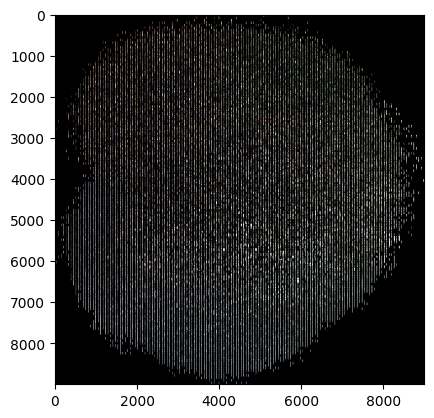

In [67]:

grid_points = projection_to_grid(150, pca_embeddings, frame_embeddings)
canvas = draw_grid(60, grid_points)
show_and_save(canvas, os.path.join(result_path, 'pca.png'))

UMAP is a clustering algorithm ,which tries to confirm to local and global structures. Being similar to T-SNE it is a visualisation/exploratory method, and thus it shoul not be interpreted too strict.

22500 items. Sort


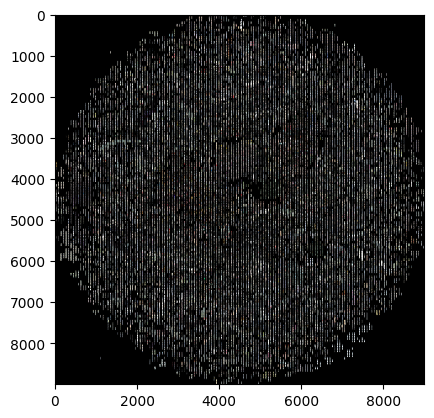

In [65]:
grid_points = projection_to_grid(150, umap_embeddings, frame_embeddings)
canvas = draw_grid(60, grid_points)
show_and_save(canvas, os.path.join(result_path, 'umap.png'))